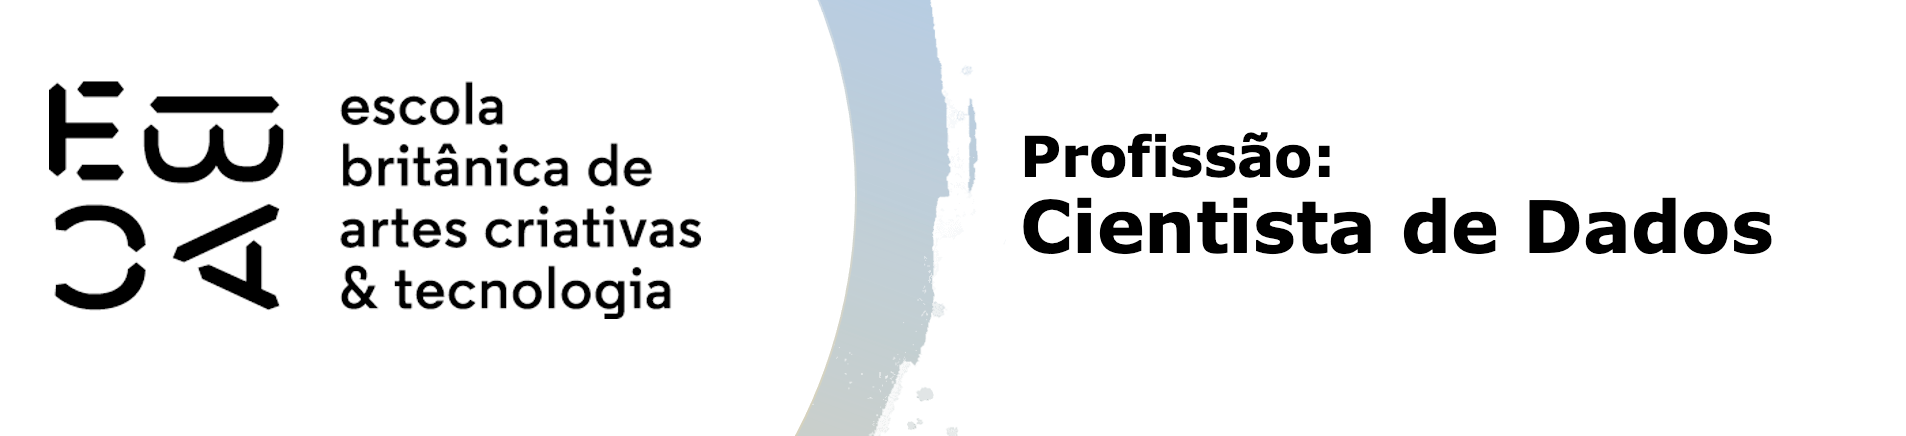

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [7]:
!pip install pycaret

In [8]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter('ignore')

In [9]:
df = pd.read_feather('./credit_scoring.ftr')
row, col = df.shape
print(f"Linhas: {row}\nColunas: {col}")
df.head()

Linhas: 750000
Colunas: 15


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [10]:
from datetime import timedelta

date_max = df['data_ref'].max()
date_minus_90 = df['data_ref'].max() - timedelta(days=90)
print(date_max, date_minus_90)

2016-03-01 00:00:00 2015-12-02 00:00:00


In [11]:
df = df.loc[df['data_ref']>= date_minus_90]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [12]:
row, col = df.shape
print(f"Base atual\nLinhas: {row}\nColunas: {col}")
print(df.data_ref.value_counts().reset_index().rename(columns={'count':'contagem'}))

Base atual
Linhas: 150000
Colunas: 15
    data_ref  contagem
0 2016-01-01     50000
1 2016-02-01     50000
2 2016-03-01     50000


In [13]:
df.isna().sum()

data_ref                     0
index                        0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            25082
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [14]:
# Excluindo colunas que não devem ser usadas
df = df.drop(columns=['data_ref', 'index'], axis=1)

### Univariada categórica

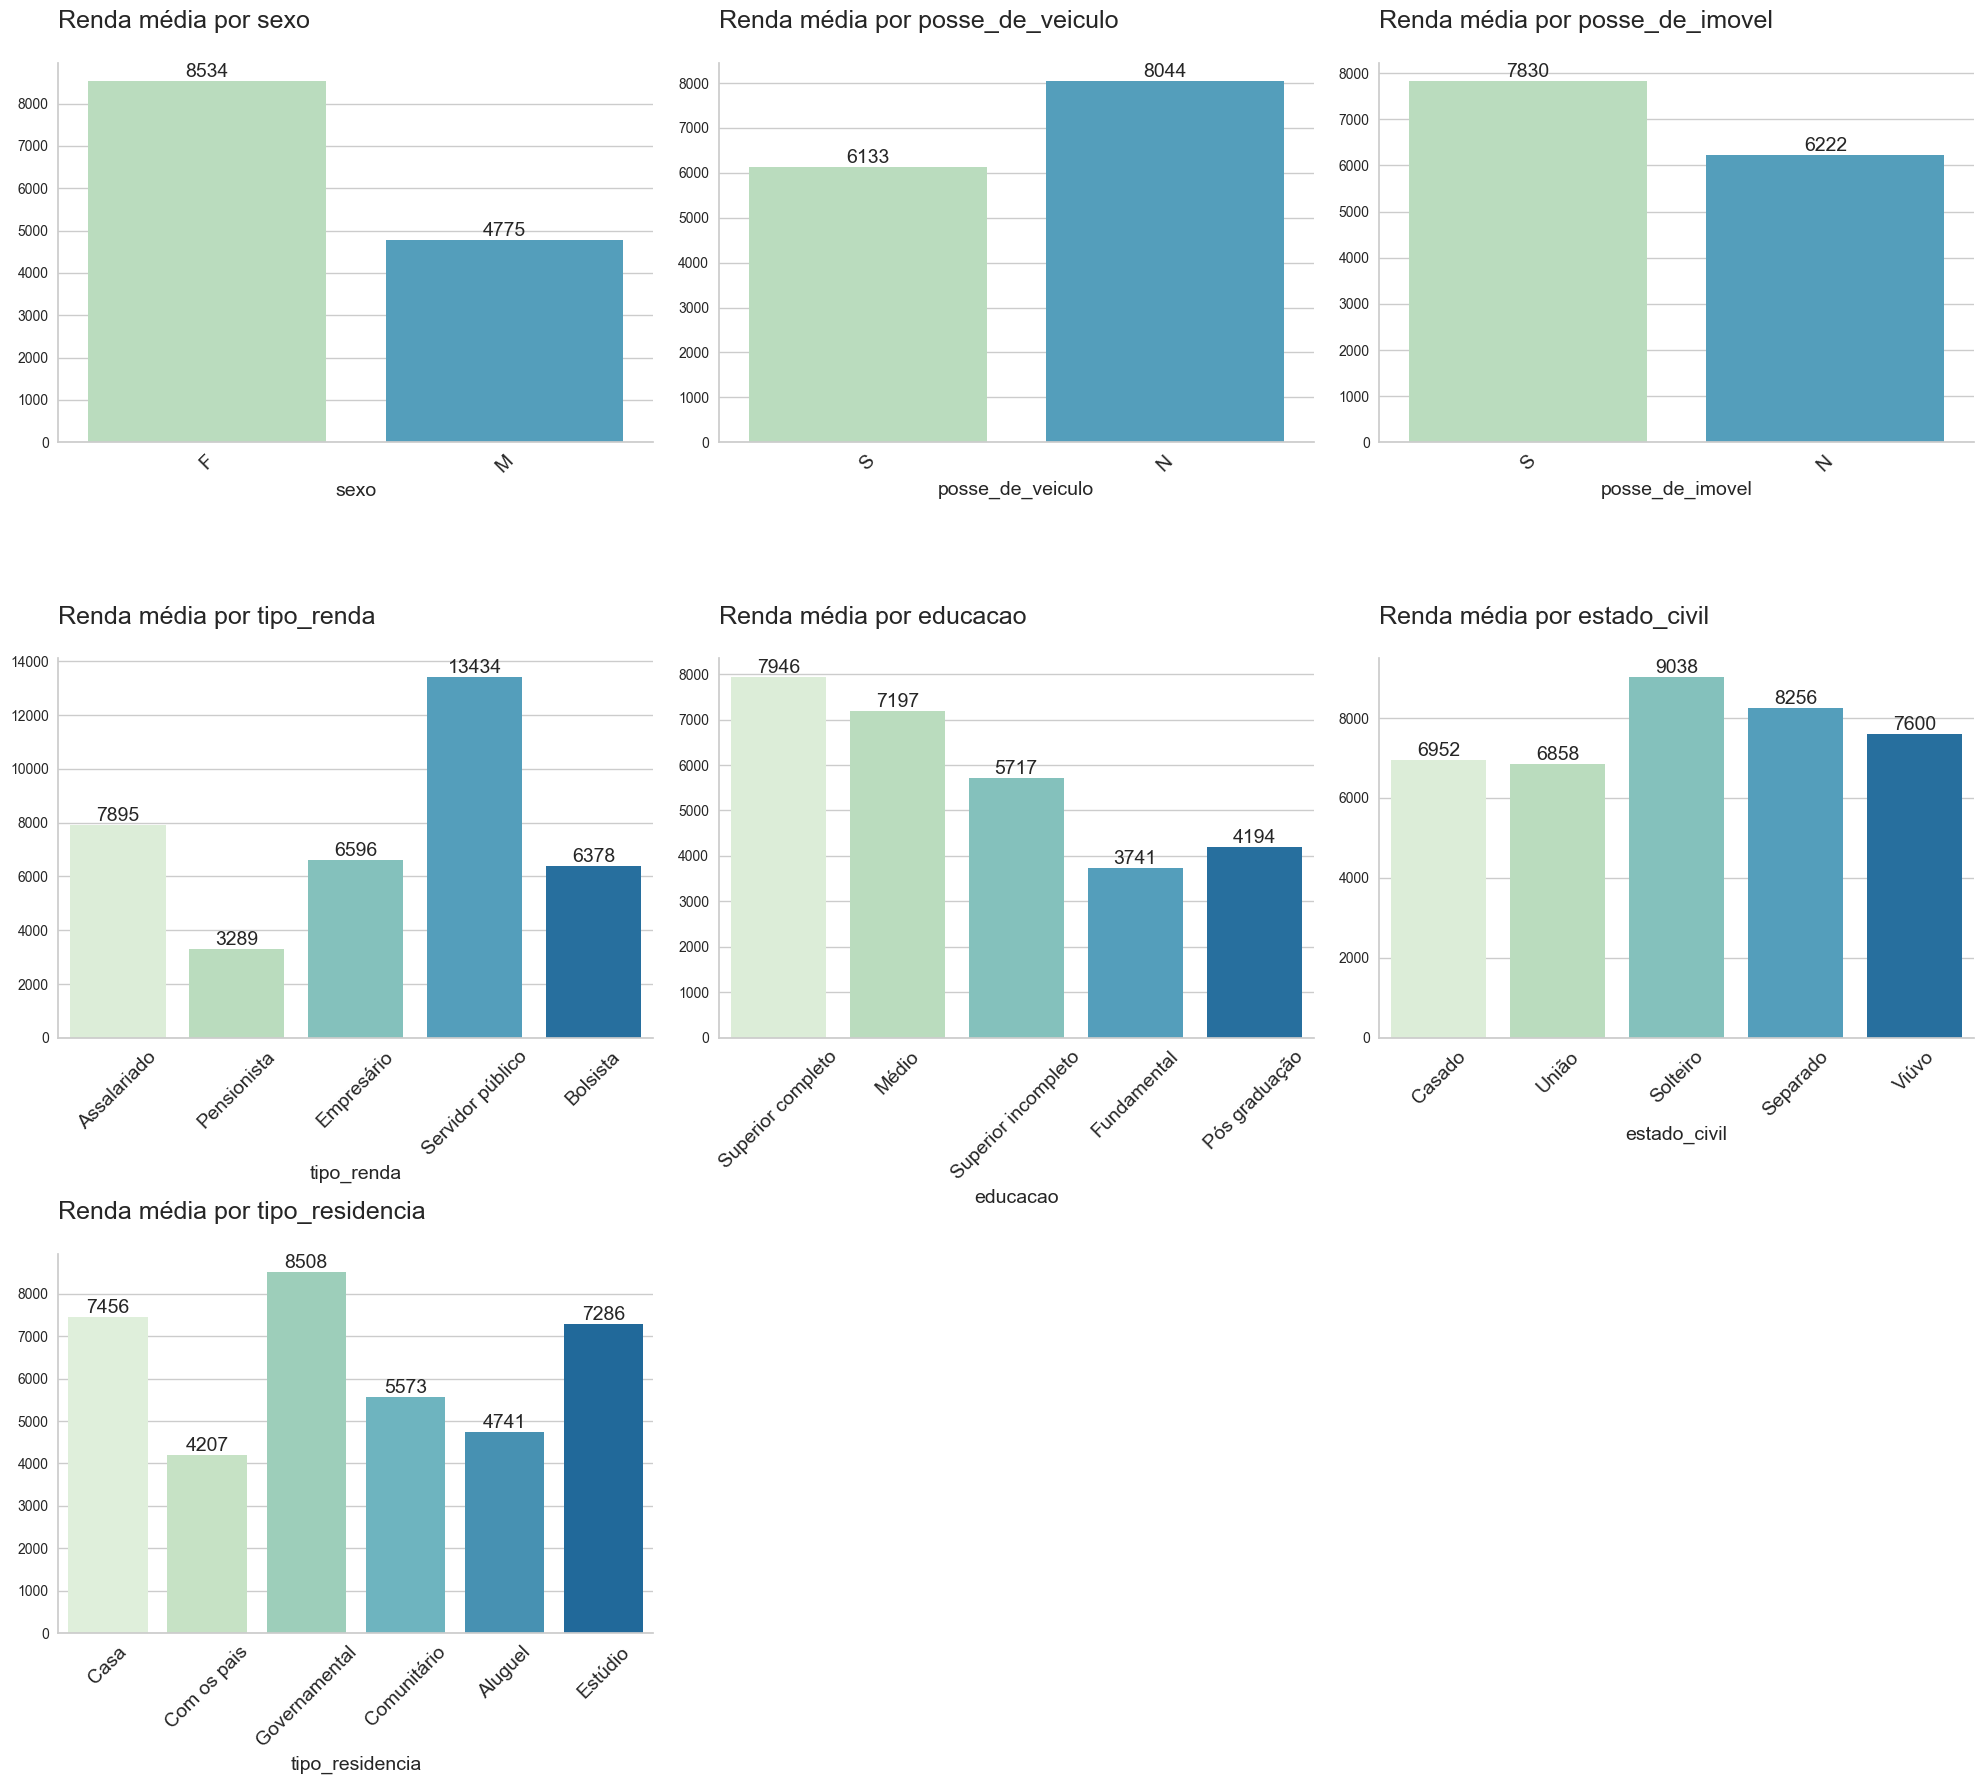

In [15]:
cat_columns = list(df.select_dtypes(include=["object"]).columns)

# Plotting categoric features
plt.figure(figsize=(20, 18))

for i, col in enumerate(cat_columns):
    ax = plt.subplot(3, 3, i+1)
    ax = sns.barplot(data=df, x=col, y=df['renda'], palette='GnBu', errorbar=None)
    ax.bar_label(ax.containers[0], fmt='%d', fontsize=14)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('')
    plt.xticks(size=14,rotation=45)
    plt.title(f'Renda média por {col}\n', loc='left', fontsize=18)
    sns.despine()
plt.tight_layout()

### Univariada numérica

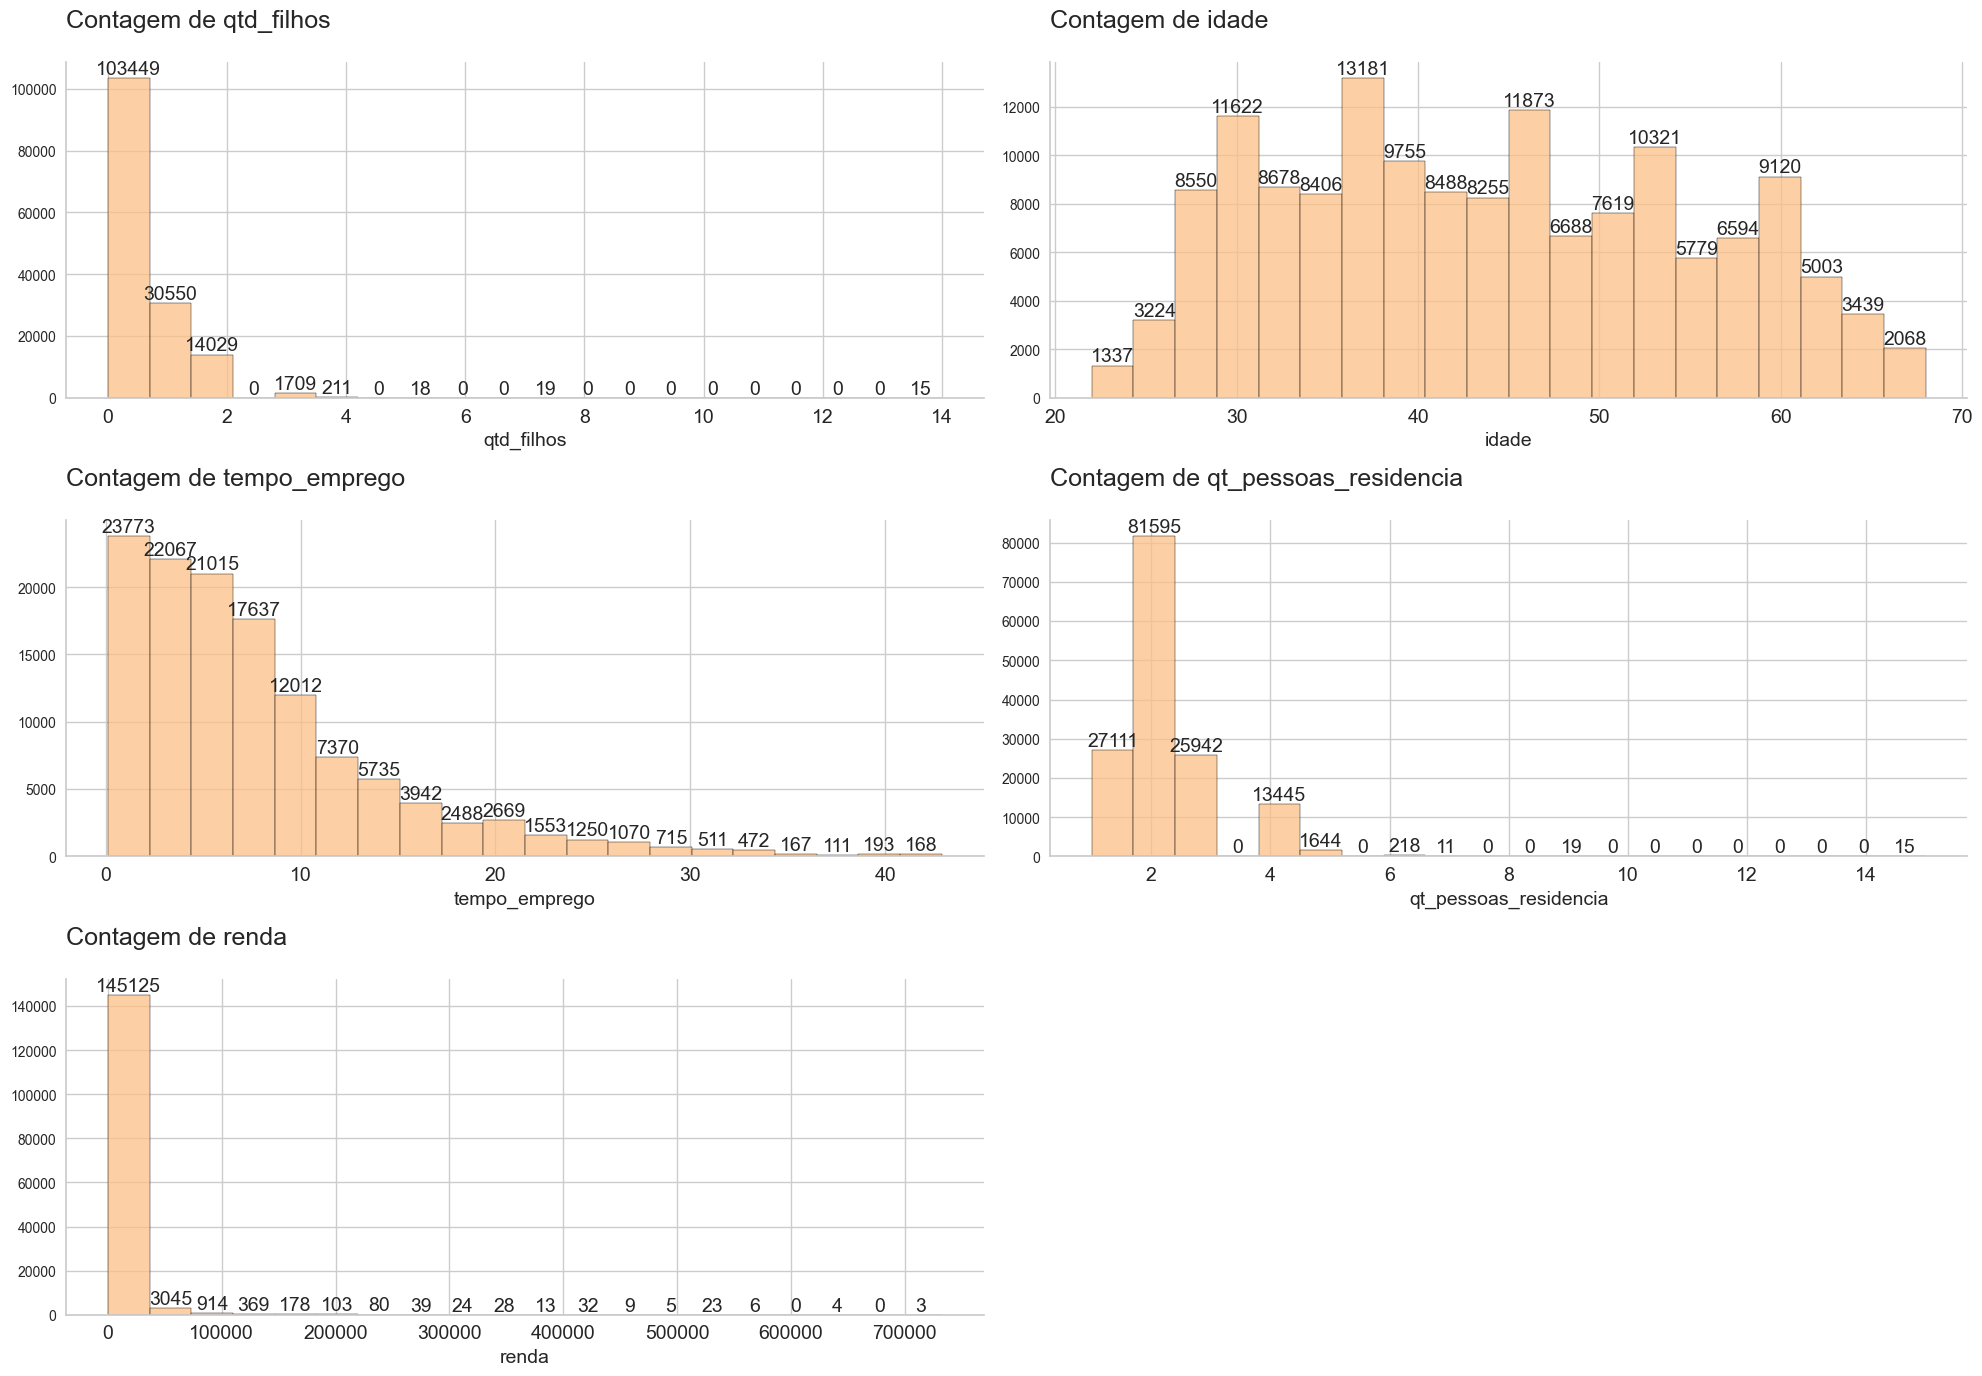

In [16]:
num_columns = list(df.select_dtypes(include=["int", "float"]).columns)

# Plotting categoric features
plt.figure(figsize=(20, 18))

columns = num_columns

for i, col in enumerate(columns):
    ax = plt.subplot(4, 2, i+1)
    ax = sns.histplot(data=df, x=col, bins=20, color="#FDC086")
    ax.bar_label(ax.containers[0], fmt='%d', fontsize=14)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('')
    plt.xticks(size=14)
    plt.title(f'Contagem de {col}\n', loc='left', fontsize=18)
    sns.despine()
plt.tight_layout()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

### Bivariada categórica

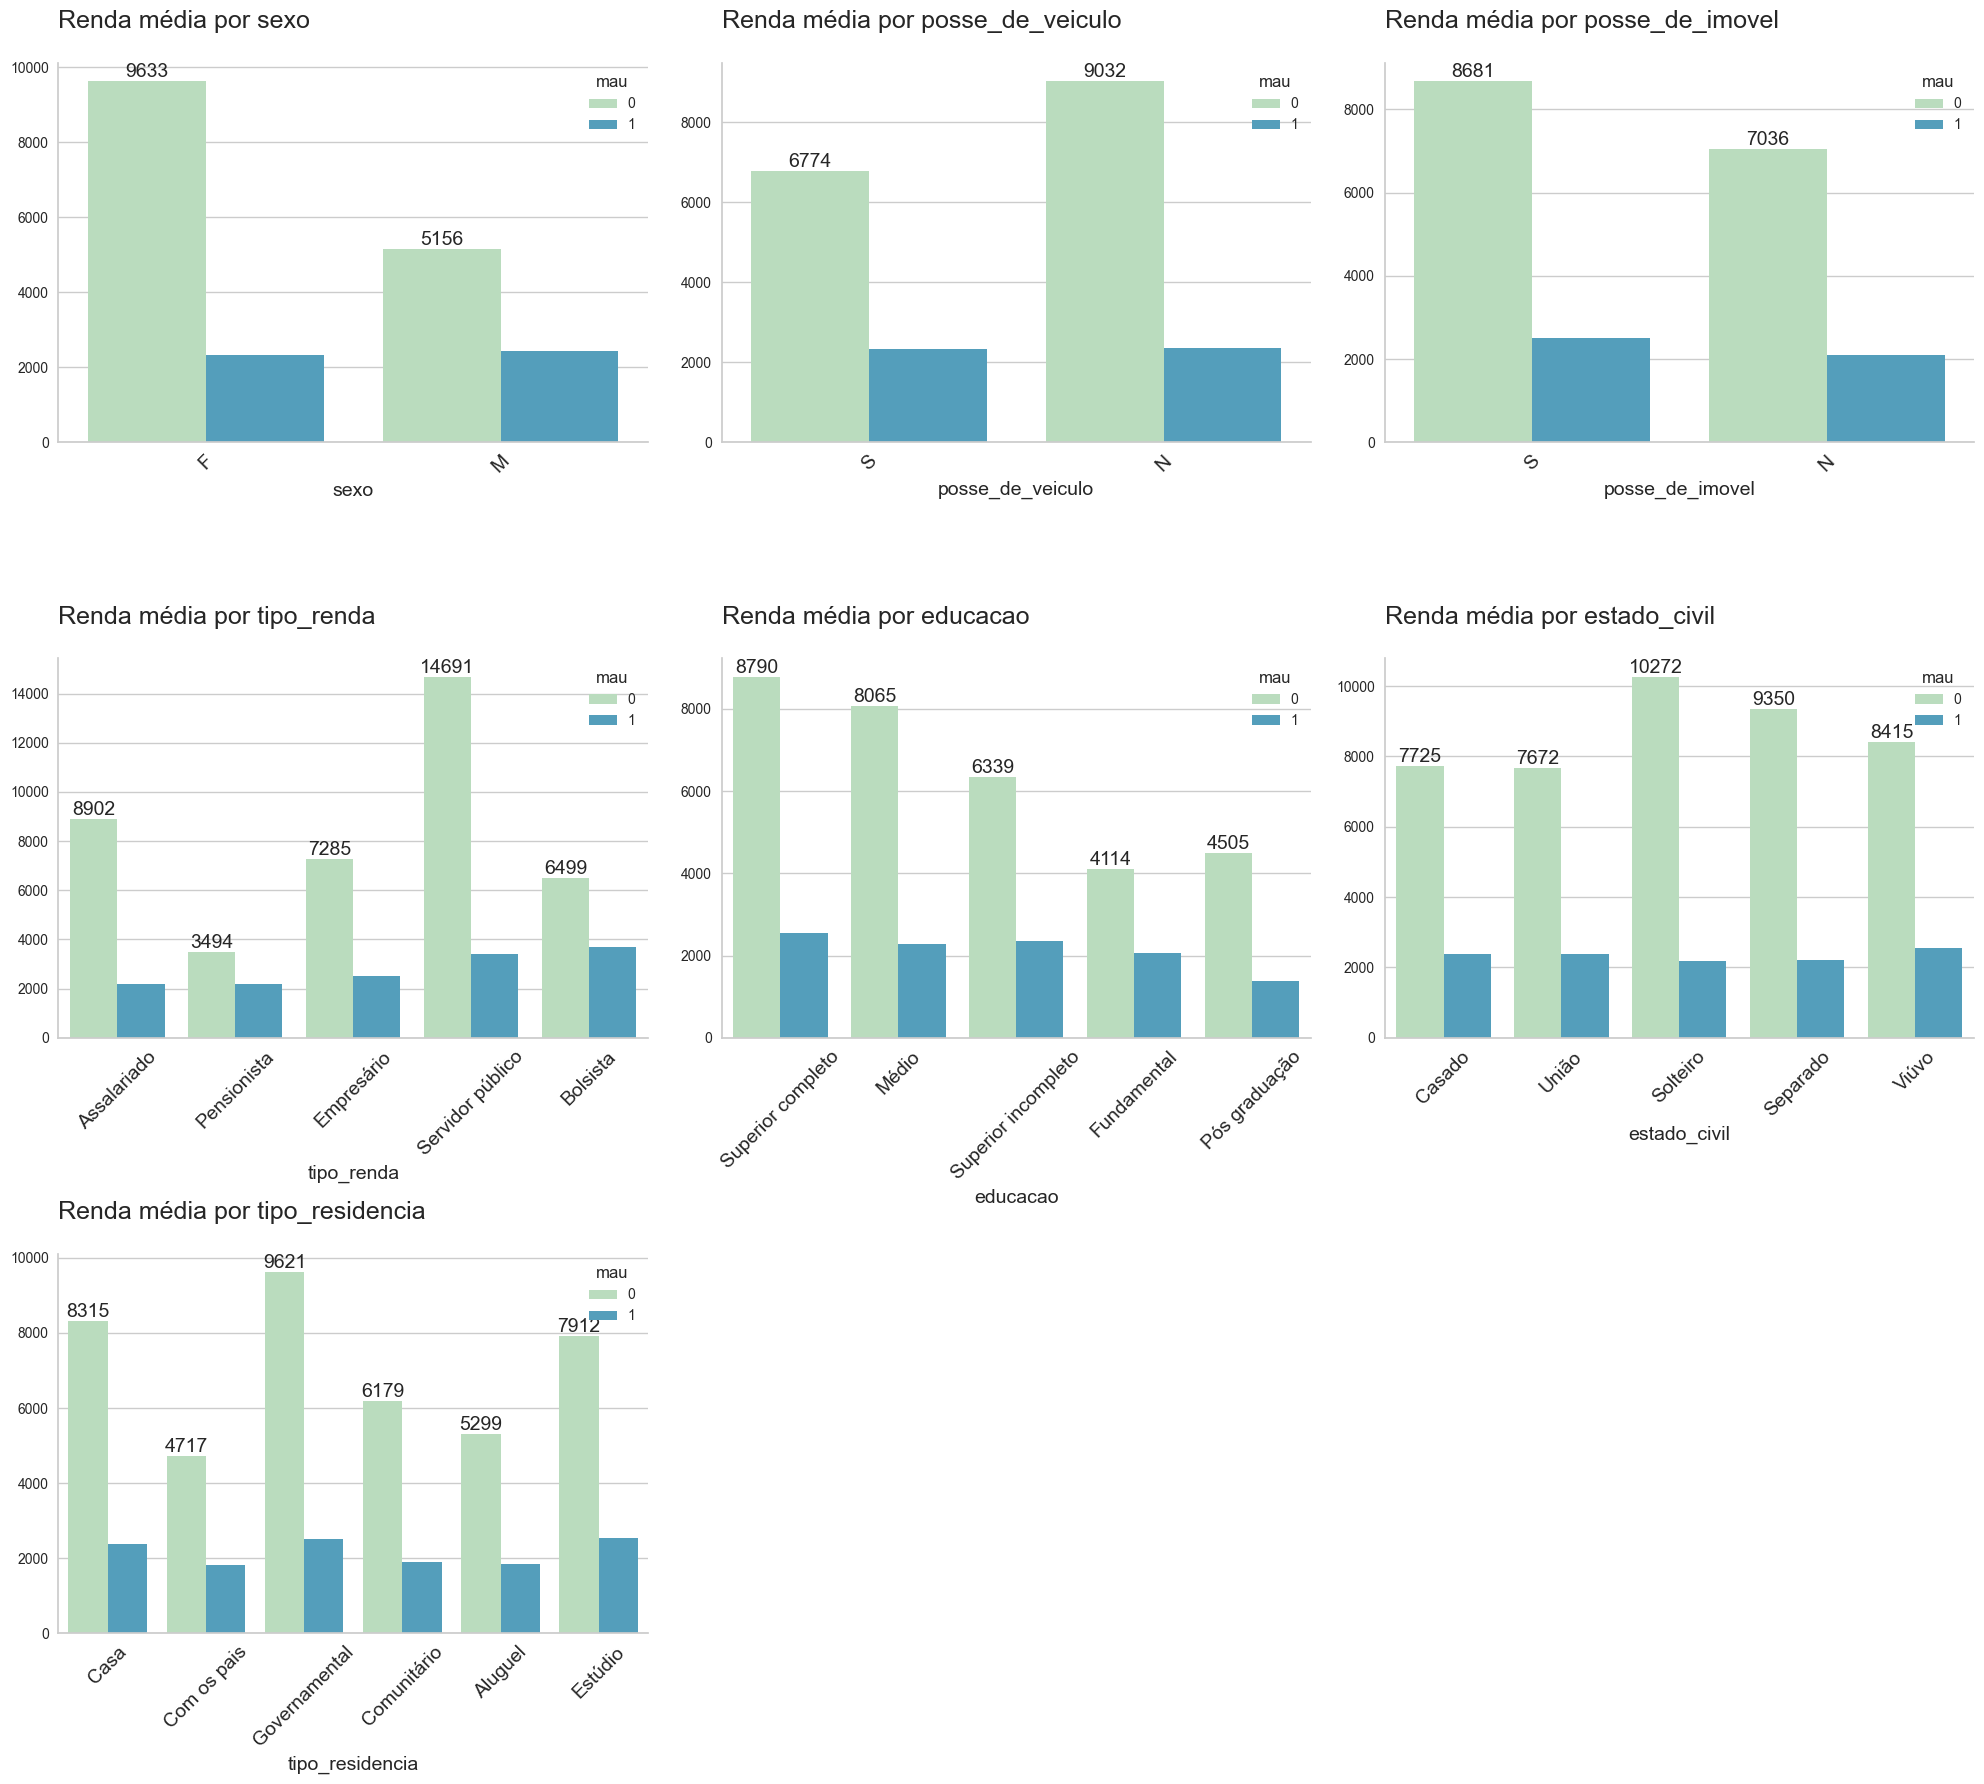

In [17]:
df['mau'] = df['mau'].astype('int')
cat_columns = list(df.select_dtypes(include=["object"]).columns)

# Plotting categoric features
plt.figure(figsize=(20, 18))

for i, col in enumerate(cat_columns):
    ax = plt.subplot(3, 3, i+1)
    ax = sns.barplot(data=df, x=col, y=df['renda'], hue=df['mau'], palette='GnBu', errorbar=None)
    ax.bar_label(ax.containers[0], fmt='%d', fontsize=14)
    # ax.bar_label(ax.containers[1], fmt='%d', fontsize=14)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('')
    plt.xticks(size=14,rotation=45)
    plt.title(f'Renda média por {col}\n', loc='left', fontsize=18)
    sns.despine()
plt.tight_layout()

### Bivariada numérica

CPU times: total: 16 s
Wall time: 16 s


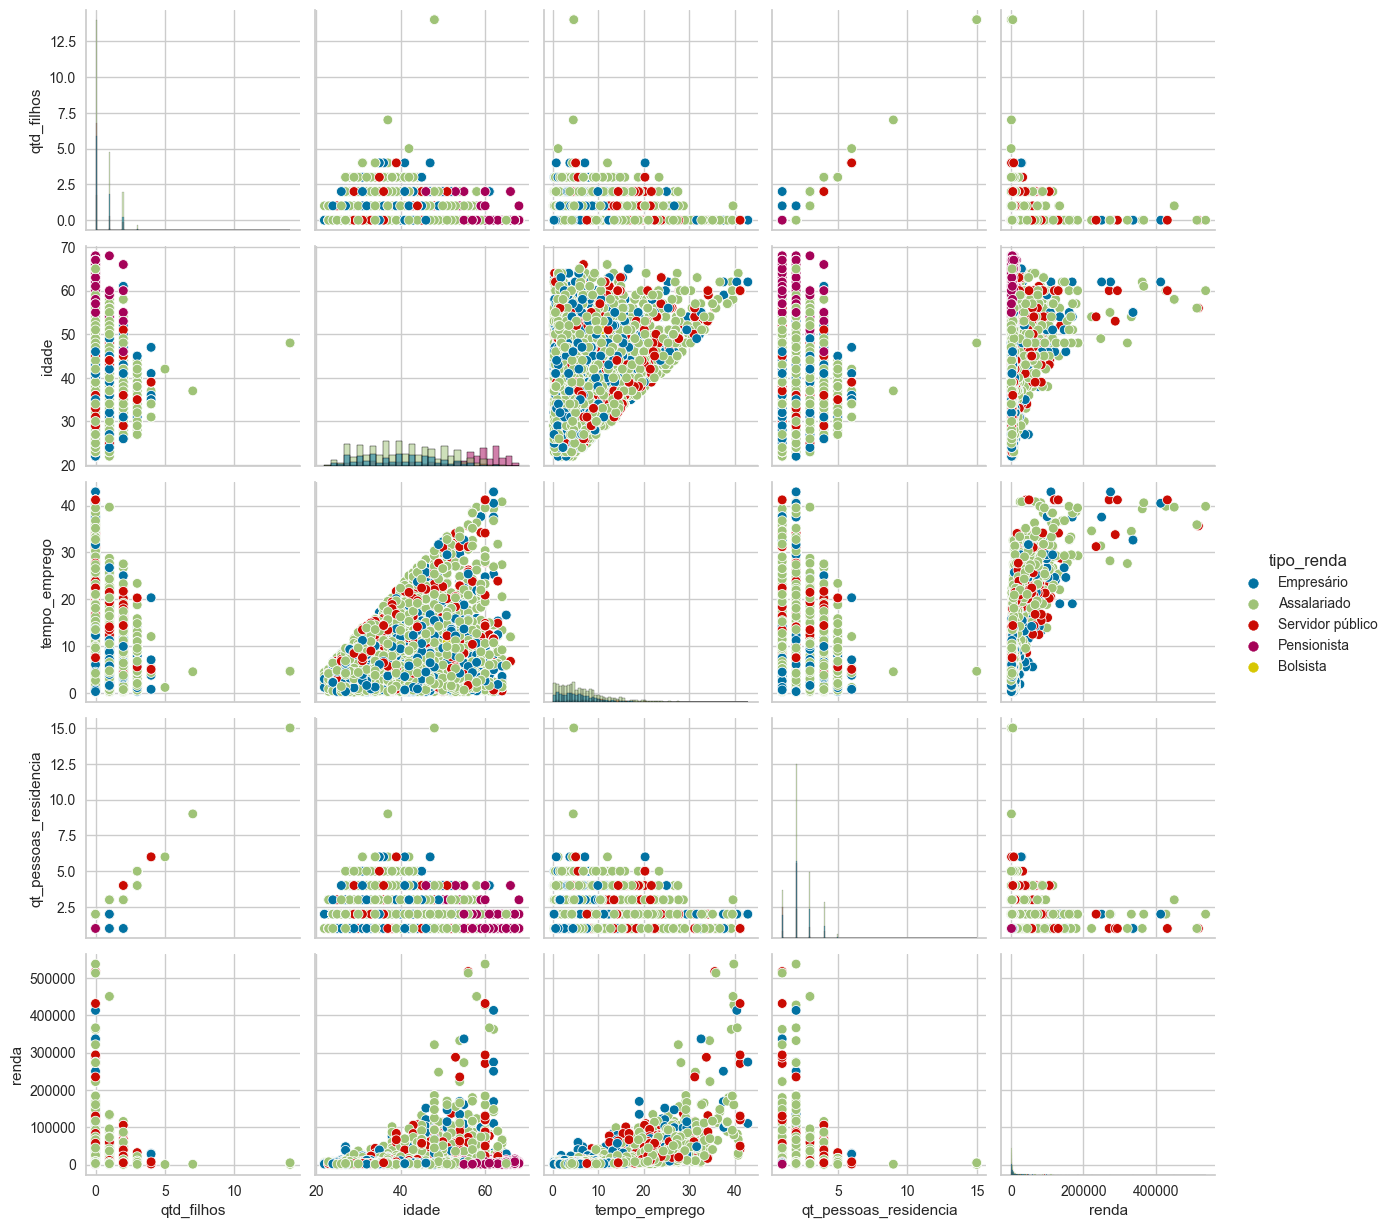

In [18]:
%%time
sample_10 = df.sample(15000)
sns.pairplot(data=sample_10,
             hue='tipo_renda',
             vars=['qtd_filhos', 
                   'idade', 
                   'tempo_emprego', 
                   'qt_pessoas_residencia', 
                   'renda'],
             diag_kind='hist')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [19]:
data = df.sample(frac=0.95, random_state=42)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (142500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (7500, 13)


In [20]:
data.index

RangeIndex(start=0, stop=142500, step=1)

In [21]:
pi_1 = setup(data = data, target = 'mau', session_id=42, experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True, remove_multicollinearity = True, multicollinearity_threshold = 0.95)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(142500, 13)"
4,Transformed data shape,"(213036, 30)"
5,Transformed train set shape,"(170286, 30)"
6,Transformed test set shape,"(42750, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


In [22]:
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8221,0.0000,0.2801,0.3610,0.3155,0.2151,0.2173
1,0.8188,0.0000,0.2719,0.3479,0.3053,0.2029,0.2049
2,0.8312,0.0000,0.2973,0.3974,0.3401,0.2456,0.2490
3,0.8238,0.0000,0.2888,0.3699,0.3244,0.2248,0.2271
4,0.8242,0.0000,0.2799,0.3681,0.3180,0.2192,0.2220
5,0.8206,0.0000,0.2758,0.3551,0.3105,0.2092,0.2114
6,0.8228,0.0000,0.2656,0.3583,0.3050,0.2060,0.2091
7,0.8250,0.0000,0.3046,0.3787,0.3376,0.2382,0.2400
8,0.8226,0.0000,0.3018,0.3703,0.3326,0.2315,0.2331


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

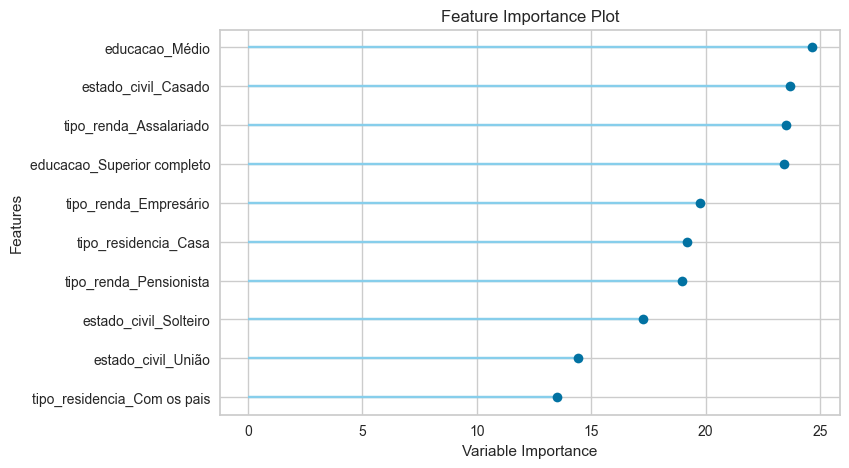

In [23]:
plot_model(lr_model, plot='feature')

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [24]:
## Accuracy
predict_pct = predict_model(lr_model, data=data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8208,0.7274,0.2945,0.3622,0.3249,0.2228,0.2244


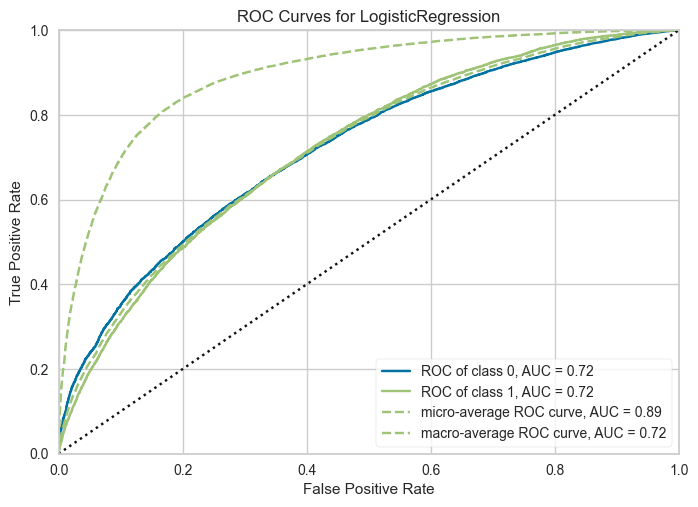

In [25]:
plot_model(lr_model, plot = 'auc')

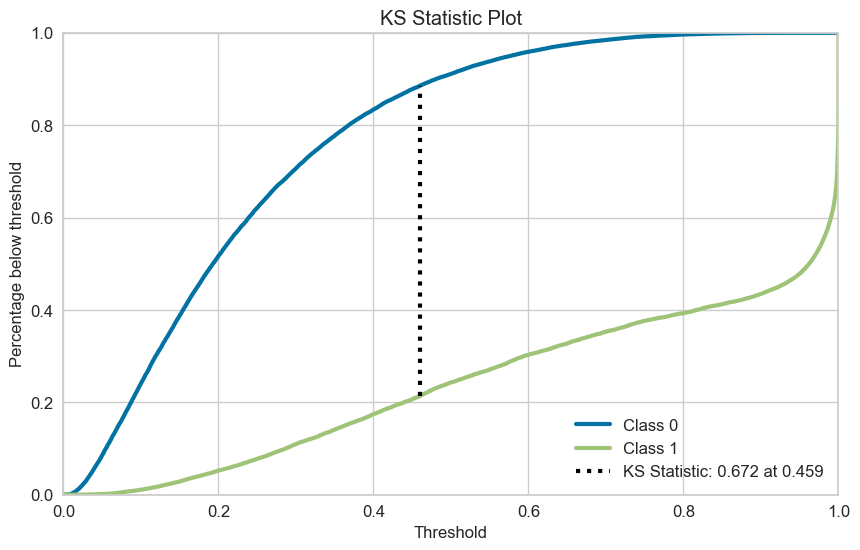

In [26]:
plot_model(lr_model, plot = 'ks')

In [27]:
unseen_predictions = predict_model(lr_model, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8215,0.7261,0.2992,0.3835,0.3361,0.2348,0.2372


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [29]:
data.isna().sum()

sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            23842
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [30]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

A estratégia do simple imputer permite preencher os valores nulos da base. Como verificamos que a única coluna com nans é o tempo_emprego, um número, os parâmetros dessa lib está configurado para substituir os valores nans pela média.

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [31]:
def remove_outliers_by_quartile(df, low_quantile=0.1, high_quantile=0.85):
    # Copy DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    # Filtering num columns
    num_columns = list(df.select_dtypes(include=["int", "float"]).columns)
    
    # Iterate over columns
    for col in num_columns:
        # Calculate lower and upper bounds using quartiles
        low_bound = df[col].quantile(low_quantile)
        high_bound = df[col].quantile(high_quantile)
        
        # Filter values based on bounds
        outliers = (df[col] < low_bound) | (df[col] > high_bound)
        
        # Replace outliers with NaN
        df_cleaned[col][outliers] = np.nan
    
    return df_cleaned
# Exemplo de uso
# df_cleaned = remove_outliers_by_quartile(data)

Nessa etapa retiramos os outliers e trocamos por nan values, em seguida preenchemos os dados com o SimpleImputer

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

Duas técnicas poderiam ser usadas, Feature impartance para usar somente as variáveis mais importante ou Recursive feature elimination para selecionar as melhores variáveis.

In [32]:
logistic_pipe = LogisticRegression(max_iter=200)
rfe = RFE(estimator=logistic_pipe, n_features_to_select=10, step=1)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [33]:
# Define a PCA to Linear dimensionality reduction
pca_pipe = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [34]:
df_dummy = pd.get_dummies(data, prefix_sep="_")

# Função para transformar todas as colunas booleanas em int
def boll_to_int(df):
    cols = list(df.select_dtypes(include="bool").columns)
    for col in cols:
        df[col] = df[col].astype('int')

# Chamando a função
boll_to_int(df_dummy)

#linhas e colunas
row, col = df_dummy.shape
print(f'Linhas: {row}\nColunas: {col}')

#Separando X e y
X = df_dummy.drop(columns=['mau'], axis=1)
y=df_dummy['mau']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Linhas: 142500
Colunas: 33


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [36]:
pipe = Pipeline(steps=[("outliers", remove_outliers_by_quartile),
                       ('replace nans', simple_imputer),
                       ("pca", pca_pipe), 
                       ("get dummies", pd.get_dummies(data, prefix_sep="_"))])

### Treinar um modelo de regressão logistica com o resultado

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
        self.lower_bound = None
        self.upper_bound = None
    
    def fit(self, X, y=None):
        self.lower_bound = np.percentile(X, 25) - self.threshold * (np.percentile(X, 75) - np.percentile(X, 25))
        self.upper_bound = np.percentile(X, 75) + self.threshold * (np.percentile(X, 75) - np.percentile(X, 25))
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[(X < self.lower_bound) | (X > self.upper_bound)] = np.nan
        return X_transformed

In [99]:
logistic_pipe = LogisticRegression(max_iter=200)

pipe = Pipeline(steps=[("outliers", OutlierTransformer()),
                       ('replace nans', simple_imputer),
                       ("pca", pca_pipe),
                       ('Logistic', logistic_pipe)])

In [100]:
lr_pipe = pipe.fit(X_train, y_train)
lr_pipe.named_steps

{'outliers': OutlierTransformer(threshold=1.5),
 'replace nans': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               keep_empty_features=False, missing_values=nan, strategy='mean'),
 'pca': PCA(copy=True, iterated_power='auto', n_components=5, n_oversamples=10,
     power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
     tol=0.0, whiten=False),
 'Logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [106]:
lr_pred = pipe.predict(X_test)
lr_pred

array([0, 0, 0, ..., 0, 0, 0])

### Salvar o pickle file do modelo treinado

In [107]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(lr_pred, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [108]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [113]:
df_setup = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(142500, 13)"
4,Transformed data shape,"(142500, 30)"
5,Transformed train set shape,"(99750, 30)"
6,Transformed test set shape,"(42750, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


In [114]:
credit_scr_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8548,0.0000,0.0555,0.5400,0.1006,0.0754,0.1376
1,0.8542,0.0000,0.0432,0.5250,0.0797,0.0588,0.1182
2,0.8538,0.0000,0.0596,0.5058,0.1066,0.0782,0.1347
3,0.8561,0.0000,0.0582,0.5903,0.1059,0.0818,0.1519
4,0.8547,0.0000,0.0472,0.5476,0.0870,0.0652,0.1283
5,0.8550,0.0000,0.0630,0.5444,0.1129,0.0851,0.1477
6,0.8536,0.0000,0.0452,0.5038,0.0829,0.0603,0.1166
7,0.8549,0.0000,0.0520,0.5507,0.0951,0.0716,0.1354
8,0.8530,0.0000,0.0561,0.4852,0.1006,0.0724,0.1258


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [115]:
tuned_credit_scr = tune_model(credit_scr_model, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8548,0.0000,0.0527,0.5423,0.0961,0.0720,0.1346
1,0.8547,0.0000,0.0668,0.5299,0.1186,0.0887,0.1487
2,0.8540,0.0000,0.0558,0.5142,0.1007,0.0741,0.1322
3,0.8549,0.0000,0.0489,0.5543,0.0899,0.0678,0.1320
4,0.8540,0.0000,0.0472,0.5169,0.0865,0.0636,0.1220
Mean,0.8545,0.0000,0.0543,0.5315,0.0984,0.0732,0.1339
Std,0.0004,0.0000,0.0069,0.0152,0.0112,0.0085,0.0086


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


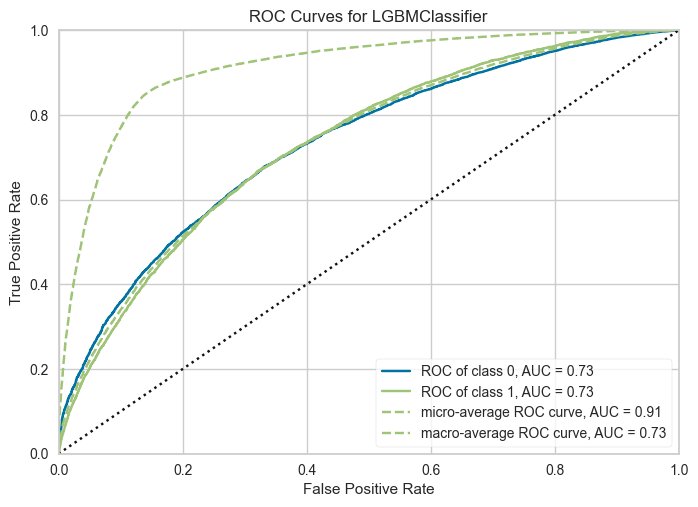

In [116]:
plot_model(tuned_credit_scr, plot = 'auc')

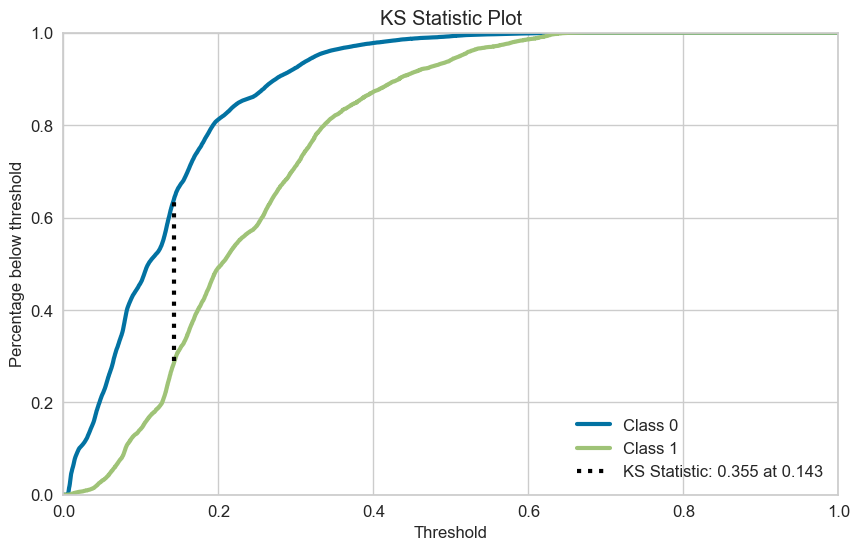

In [117]:
plot_model(tuned_credit_scr, plot='ks')

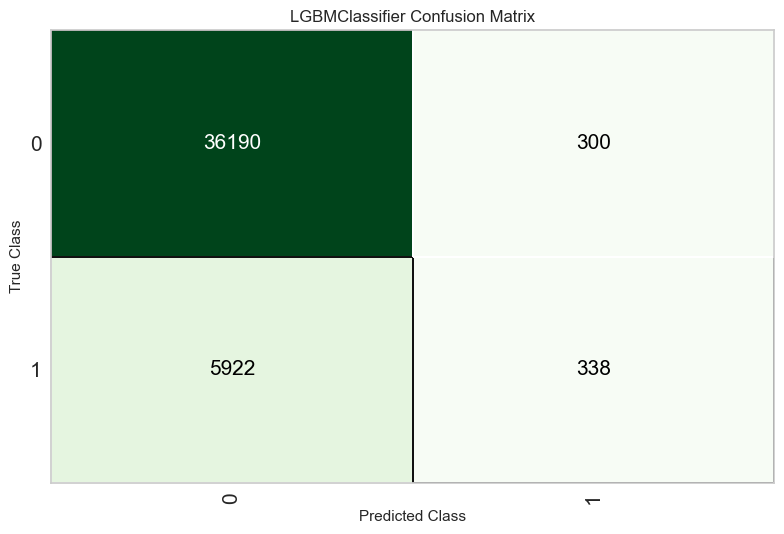

In [118]:
plot_model(tuned_credit_scr, plot='confusion_matrix')

In [120]:
predict_model(tuned_credit_scr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8545,0.7327,0.0540,0.5298,0.0980,0.0729,0.1335


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [121]:
final_credit_scr = finalize_model(tuned_credit_scr)

In [122]:
predict_model(final_credit_scr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8553,0.7383,0.0527,0.5622,0.0964,0.0731,0.1388


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [127]:
unseen_data = predict_model(final_credit_scr, data=data_unseen)
unseen_data.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8496,0.7410,0.0459,0.5253,0.0844,0.0616,0.1208


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,N,3,Assalariado,Superior completo,Casado,Casa,30,1.093151,5.0,1297.359985,1,0,0.7456
1,F,S,S,1,Assalariado,Médio,Casado,Casa,46,3.468493,3.0,2688.969971,0,0,0.8764
2,M,N,N,2,Assalariado,Superior completo,União,Casa,45,8.460274,4.0,22977.609375,0,0,0.9861
3,M,N,N,0,Servidor público,Médio,Solteiro,Casa,28,5.457534,1.0,946.190002,0,0,0.6962
4,F,N,N,1,Empresário,Médio,Casado,Governamental,49,9.931507,3.0,12406.849609,0,0,0.9559


### Salvar o arquivo do modelo treinado

In [128]:
save_model(final_credit_scr,'Final lgbm Model 01Apr2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.